# ML Classifier Copies - Imbalanced Problem

When we talk about imbalance in ML Classifier Copies we are not referring to the balance between classes provided by the original dataset, which is in principle not accessible and thus it does not have any effect in the copy. We are referring to the imbalance of the synthetic dataset used to generate the copy.

Such an imbalance arises from a combination of the particular topology of the class boundaries learned by the original classifier and the sampling strategy to perform the copy. For instance, when using samplers that probe the space uniformly, the probability of having a class in the synthetic dataset is proportional to the volume of the space defined by its boundaries. Or when using a spherical sampler that assumes a gaussian distribution of the features, the probability of having a class in the synthetic dataset might increase for those classes that are located closer to the origin with respect to those in the outskirts, even if they occupy a similar volume.

The copy classifier is normally built using generated data randomly sampled from the whole space, hence, this process will normally tend to generate many more samples for classes that are described by the classifier as occupying a much larger hypervolume. Therefore, it will be the generated data used to train the copy classifier which becomes imbalanced.

To tackle this problem, a mechanism has been introduced to force the balance between classes when generating the synthetic data. Such option can be used with any of the sampling functions by setting the `enforce_balance` as `True`.

<a name="Index">
    
----
# Table of contents

    
1. [**Generated imbalanced problem**](#Problem)
2. [**Fit and evaluate original classifiers**](#Original)
3. [**Imbalanced classifier copies**](#Imbalanced)
    1. [Linear SVC to Decision Tree Classifier (imbalanced)](#SVC2tree_imbalance)
    2. [Decision Tree Classifier to Linear SVC (imbalanced)](#Tree2SVC_imbalance)
4. [**Balanced classifier copies**](#Balanced)
    1. [Linear SVC to Decision Tree Classifier (balanced)](#SVC2tree_balance)
    2. [Decision Tree Classifier to Linear SVC (balanced)](#Tree2SVC_balance)
5. [**Summary of results**](#Results)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.sampling import (dynamical_range, find_categories, build_equal_category_dict,
                                   mixed_data_features, grid_sampling, uniform_sampling, 
                                   normal_sampling, categorical_sampling, mixed_data_sampling, labeling,
                                   sampling_balancer)

[Index](#Index)  
  
  


<a name="Problem">  

-----
-----
# Generated imbalanced problem

#### Small dimensionality (number of features=3).

In [4]:
nsamples = 1000
nproblems = 1
nfeatures = 3
nclasses = 3
scale = 8

class_samples = int(nsamples / nclasses)
t_pred = scale * np.random.normal(0, 1, (class_samples, nfeatures))
df_pred = pd.DataFrame(t_pred)
df_pred["class"] = 0

# Create additional classes centered at `m` with standard deviation `scale`
for i in range(1, nclasses):
    # Generate a normalized vector in a random direction
    v = np.random.normal(0, 1, nfeatures)
    v = v / np.linalg.norm(v)

    # Generate a random distance from the origin to define the center of each gaussian
    alpha = [15,15][i-1]
    m = alpha * v

    # Generate a random scaling for each gaussian
    scale = [0.3,0.3][i-1]

    # Generate normally distributed random samples for this classs
    t = m + scale * np.random.normal(0, 1, (class_samples, nfeatures))
    df = pd.DataFrame(t)
    df["class"] = i

    # Add class data to the dataset
    df_pred = pd.concat([df_pred, df], ignore_index=True)

# Convert into PRESC Dataset
df_presc = Dataset(df_pred, label_col="class")

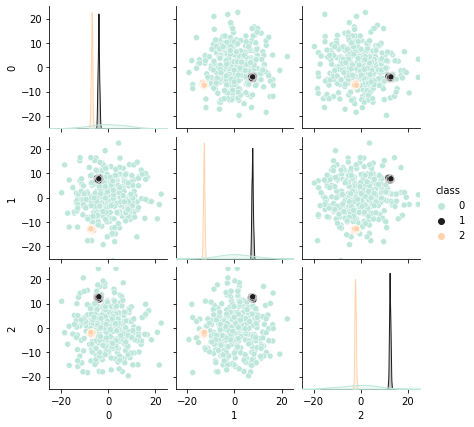

In [5]:
g = sns.pairplot(df_presc.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-25,25), ylim = (-25,25))#, , kind="kde")
plt.show()

### Dynamical range

In [6]:
%%capture
feature_description = dynamical_range(df_presc.features)
feature_description

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Fit and evaluate original classifiers

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df_presc.features, df_presc.labels, 
                                                    test_size=0.40, random_state=42)
df_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
df_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)

# Linear SVC Classifier
original_SVC_classifier = SVC(kernel='rbf', decision_function_shape='ovo')
original_SVC_classifier.fit(X_train, y_train)

# Linear SVC Classifier Evaluation
y_predicted_original_SVC = original_SVC_classifier.predict(X_test)
score_original_SVC = original_SVC_classifier.score(X_test, y_test)
report_original_SVC = classification_report(y_test, y_predicted_original_SVC)

# Decision Tree Classifier
original_tree_classifier = DecisionTreeClassifier(max_depth=3)
original_tree_classifier.fit(X_train, y_train)

# Decision Tree Classifier Evaluation
y_predicted_original_tree = original_tree_classifier.predict(X_test)
score_original_tree = original_tree_classifier.score(X_test, y_test)
report_original_tree = classification_report(y_test, y_predicted_original_tree)

print(f"\nNumber of features = {nfeatures:.0f}")
print(f"\nScore of SVC classifier = {score_original_SVC:.4f}")
print("\n", report_original_SVC)
print(f"------------------------------------------------------\n")
print(f"Score of decision tree classifier = {score_original_tree:.4f}")
print("\n", report_original_tree)


Number of features = 3

Score of SVC classifier = 0.9775

               precision    recall  f1-score   support

           0       1.00      0.94      0.97       146
           1       0.96      1.00      0.98       129
           2       0.97      1.00      0.98       125

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

------------------------------------------------------

Score of decision tree classifier = 0.9975

               precision    recall  f1-score   support

           0       1.00      0.99      1.00       146
           1       0.99      1.00      1.00       129
           2       1.00      1.00      1.00       125

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



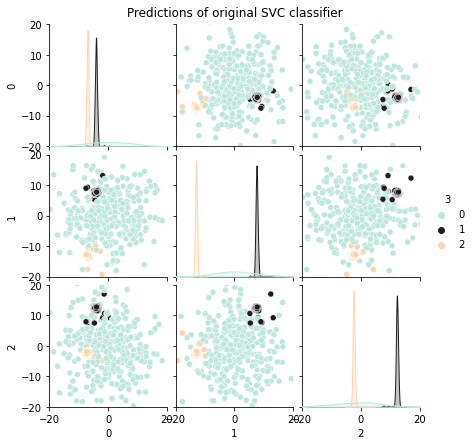

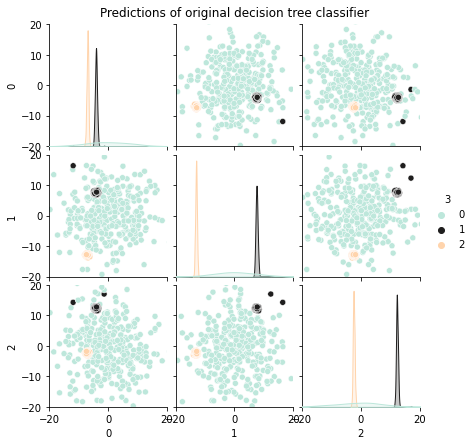

In [8]:
dataset_predicted_tree = Dataset(pd.concat([pd.DataFrame(df_presc.features), 
                                            pd.DataFrame(original_tree_classifier.predict(df_presc.features))], 
                                           axis=1, join="inner", ignore_index=True), label_col=3) 
dataset_predicted_SVC = Dataset(pd.concat([pd.DataFrame(df_presc.features), 
                                            pd.DataFrame(original_SVC_classifier.predict(df_presc.features))], 
                                           axis=1, join="inner", ignore_index=True), label_col=3)
g = sns.pairplot(dataset_predicted_SVC.df, vars=[i for i in range(nfeatures)], hue=3, 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
g.fig.suptitle("Predictions of original SVC classifier", y=1.02)
plt.show()
g = sns.pairplot(dataset_predicted_tree.df, vars=[i for i in range(nfeatures)], hue=3, 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
g.fig.suptitle("Predictions of original decision tree classifier", y=1.02)
plt.show()

[Index](#Index)  
  
  


<a name="Imbalanced"> 

----
----
# Imbalanced sampling

<a name="SVC2tree_unbalance"> 

### Linear SVC original to Decision Tree copy (imbalanced)

In [9]:
# Create decision tree copy
classifier_copy = DecisionTreeClassifier(max_depth=2)
normal_SVC2tree_copy = ClassifierCopy(original_SVC_classifier, classifier_copy, normal_sampling, nsamples=200, 
                                      random_state=42, feature_parameters=feature_description, label_col="class") 
normal_SVC2tree_training = normal_SVC2tree_copy.copy_classifier(get_training_data=True)

# Copy Evaluaton summary with original test and synthetic test datasets
synthetic_test_data = normal_SVC2tree_copy.generate_synthetic_data(nsamples=200, random_state=43)
evaluation_SVC2tree_imbalanced = normal_SVC2tree_copy.evaluation_summary(test_data=Dataset(df_test, 
                                                 label_col="class"), synthetic_data=synthetic_test_data)

Original Model Accuracy (test)          0.9775
Copy Model Accuracy (test)              0.3650
Empirical Fidelity Error (synthetic)    0.1200
Empirical Fidelity Error (test)         0.6575
Replacement Capability (synthetic)      0.8800
Replacement Capability (test)           0.3734


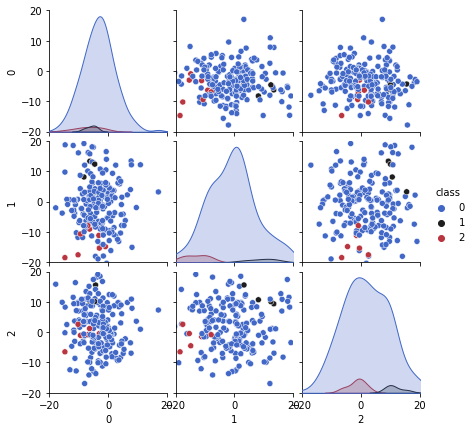

In [10]:
g = sns.pairplot(normal_SVC2tree_training.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
plt.show()

#### Synthetic samples from each class

In [11]:
normal_SVC2tree_training.df.value_counts("class")

class
0    188
2      8
1      4
dtype: int64

[Index](#Index)  
  
  


<a name="Tree2SVC_imbalance"> 

### Decision Tree original to Linear SVC copy (imbalanced)

In [12]:
classifier_copy = SVC(kernel='rbf', decision_function_shape='ovo', gamma=0.01)
normal_tree2SVC_copy = ClassifierCopy(original_tree_classifier, classifier_copy, normal_sampling, nsamples=200, 
                                      random_state=42, feature_parameters=feature_description, label_col="class") 
normal_tree2SVC_training = normal_tree2SVC_copy.copy_classifier(get_training_data=True)

# Copy Evaluaton summary with original test and synthetic test datasets
synthetic_test_data = normal_tree2SVC_copy.generate_synthetic_data(nsamples=200, random_state=43)
evaluation_tree2SVC_imbalanced = normal_tree2SVC_copy.evaluation_summary(test_data=Dataset(df_test, 
                                                    label_col="class"), synthetic_data=synthetic_test_data)

Original Model Accuracy (test)          0.9975
Copy Model Accuracy (test)              0.3650
Empirical Fidelity Error (synthetic)    0.0900
Empirical Fidelity Error (test)         0.6375
Replacement Capability (synthetic)      0.9100
Replacement Capability (test)           0.3659


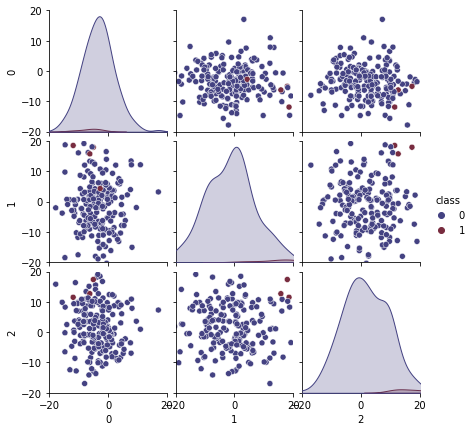

In [13]:
g = sns.pairplot(normal_tree2SVC_training.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
plt.show()

#### Synthetic samples from each class

In [14]:
normal_tree2SVC_training.df.value_counts("class")

class
0    196
1      4
dtype: int64

[Index](#Index)  
  
  


<a name="Balanced"> 

# Balanced sampling

In [15]:
balance_parameters={"max_iter": 50, "nbatch": 150, "verbose": False}

<a name="SVC2tree_spherical"> 

### Linear SVC original to Decision Tree copy (balanced)

In [16]:
# Create decision tree copy
classifier_copy = DecisionTreeClassifier(min_samples_leaf=4)
normal_SVC2tree_copy = ClassifierCopy(original_SVC_classifier, classifier_copy, normal_sampling,
                                      enforce_balance=True, nsamples=200, random_state=42,
                                      feature_parameters=feature_description, label_col="class",
                                      **balance_parameters) 
normal_SVC2tree_training = normal_SVC2tree_copy.copy_classifier(get_training_data=True)

# Copy Evaluaton summary with original test and synthetic test datasets
synthetic_test_data = normal_SVC2tree_copy.generate_synthetic_data(nsamples=200, random_state=43)
evaluation_SVC2tree_balanced = normal_SVC2tree_copy.evaluation_summary(test_data=Dataset(df_test, 
                                                label_col="class"), synthetic_data=synthetic_test_data)

Original Model Accuracy (test)          0.9775
Copy Model Accuracy (test)              0.9725
Empirical Fidelity Error (synthetic)    0.0657
Empirical Fidelity Error (test)         0.0100
Replacement Capability (synthetic)      0.9343
Replacement Capability (test)           0.9949


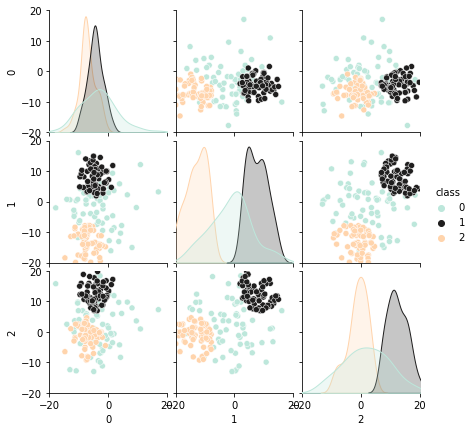

In [17]:
g = sns.pairplot(normal_SVC2tree_training.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
plt.show()

#### Synthetic samples from each class

In [18]:
normal_SVC2tree_training.df.value_counts("class")

class
0    66
1    66
2    66
dtype: int64

[Index](#Index)  
  
  


<a name="Tree2SVC_spherical"> 


### Decision Tree original to Linear SVC copy (balanced)

In [19]:
classifier_copy = SVC(kernel='rbf', decision_function_shape='ovo', gamma=0.01)
normal_tree2SVC_copy = ClassifierCopy(original_tree_classifier, classifier_copy, normal_sampling,
                                      enforce_balance=True, nsamples=200, random_state=42,
                                      feature_parameters=feature_description, label_col="class",
                                      **balance_parameters) 
normal_tree2SVC_training = normal_tree2SVC_copy.copy_classifier(get_training_data=True)

# Copy Evaluaton summary with original test and synthetic test datasets
synthetic_test_data = normal_tree2SVC_copy.generate_synthetic_data(nsamples=200, random_state=43)
evaluation_tree2SVC_balanced = normal_tree2SVC_copy.evaluation_summary(test_data=Dataset(df_test, 
                                                        label_col="class"), synthetic_data=synthetic_test_data)

Original Model Accuracy (test)          0.9975
Copy Model Accuracy (test)              0.9700
Empirical Fidelity Error (synthetic)    0.0606
Empirical Fidelity Error (test)         0.0275
Replacement Capability (synthetic)      0.9394
Replacement Capability (test)           0.9724


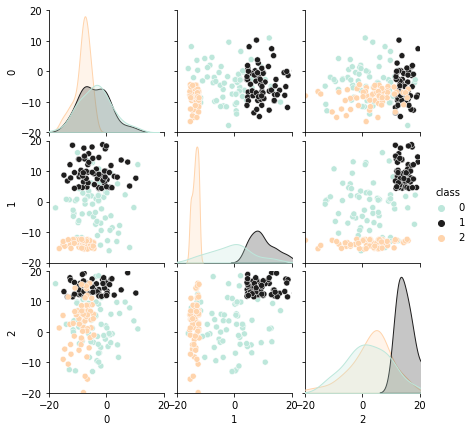

In [20]:
g = sns.pairplot(normal_tree2SVC_training.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
plt.show()

#### Synthetic samples from each class

In [21]:
normal_tree2SVC_training.df.value_counts("class")

class
0    66
1    66
2    66
dtype: int64

[Index](#Index)  
  
  


<a name="Results">

----
## Results summary

Clearly, using the balancing option for the sampler yields better results than not using them:

In [22]:
evaluation_SVC2tree_imbalanced

{'Original Model Accuracy (test)': 0.9775,
 'Copy Model Accuracy (test)': 0.365,
 'Empirical Fidelity Error (synthetic)': 0.12,
 'Empirical Fidelity Error (test)': 0.6575,
 'Replacement Capability (synthetic)': 0.88,
 'Replacement Capability (test)': 0.3734015345268542}

In [23]:
evaluation_SVC2tree_balanced

{'Original Model Accuracy (test)': 0.9775,
 'Copy Model Accuracy (test)': 0.9725,
 'Empirical Fidelity Error (synthetic)': 0.06565656565656564,
 'Empirical Fidelity Error (test)': 0.010000000000000009,
 'Replacement Capability (synthetic)': 0.9343434343434344,
 'Replacement Capability (test)': 0.9948849104859335}

In [24]:
evaluation_tree2SVC_imbalanced

{'Original Model Accuracy (test)': 0.9975,
 'Copy Model Accuracy (test)': 0.365,
 'Empirical Fidelity Error (synthetic)': 0.08999999999999997,
 'Empirical Fidelity Error (test)': 0.6375,
 'Replacement Capability (synthetic)': 0.91,
 'Replacement Capability (test)': 0.3659147869674185}

In [25]:
evaluation_tree2SVC_balanced

{'Original Model Accuracy (test)': 0.9975,
 'Copy Model Accuracy (test)': 0.97,
 'Empirical Fidelity Error (synthetic)': 0.06060606060606055,
 'Empirical Fidelity Error (test)': 0.02749999999999997,
 'Replacement Capability (synthetic)': 0.9393939393939394,
 'Replacement Capability (test)': 0.9724310776942355}

[Index](#Index)  
  
  

----